# Average Path Length Distributions

In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import pickle, json, os, sys, csv, random, operator
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import utils
import netprop

## Load datasets

In [4]:
path = 'data/networks'
paths = [os.path.join(path, f) for f in os.listdir(path) if not f.startswith('.')]

networks = {}
for gpath in paths:
    fname = gpath.rsplit('/', 1)[-1].split('.')[0]
    networks[fname] = ig.Graph.Read_Pickle(gpath)
    print fname
    print networks[fname].summary()

acl
IGRAPH DN-- 18665 115311 -- 
+ attr: attributed (g), attributes (g), single_attr (g), attrs (v), id (v), name (v), single_attr (v), time (v), venue_id (v)
hepph
IGRAPH DN-- 30558 347228 -- 
+ attr: attributed (g), attributes (g), single_attr (g), month (v), name (v), time (v), year (v)
judicial
IGRAPH DN-- 30288 216738 -- 
+ attr: attributed (g), attributes (g), single_attr (g), name (v), time (v)


## Load APL data

In [70]:
def get_path_length_data(fpath, get_all_data=False):
    """parse path length data and return apl distribution"""
    nid_dists = defaultdict(lambda: defaultdict(int))
    pl_data = defaultdict(list)
    fgen = utils.get_spaced_data_generator(fpath, proc=lambda l: map(int, l))

    # log data from file
    for (nid, length, freq) in fgen:
        nid_dists[nid][length] = freq
    # compute dist for each node
    for nid, freq_dict in nid_dists.iteritems():
        total = float(sum(freq_dict.values()))
        pmf = nid_dists[nid] = {k:v/total for k,v in freq_dict.iteritems()}
        
        # aggregate path length probabilities
        for length, prob in pmf.iteritems():
            pl_data[length].append(prob)
            
    if get_all_data: return pl_data
    
    pl_mean = {k: np.mean(v) for k,v in pl_data.iteritems()}
    xk, pk = zip(*sorted(pl_mean.items()))
    pk_std = [np.std(pl_data[x]) for x in xk]
    return xk, pk, pk_std, pl_data

In [66]:
files = ['acl', 'hepph', 'judicial', 'semantic', 'aps']
fld_path = 'data/path_length_outputs/'
pl_data = {f: get_path_length_data(os.path.join(fld_path, '{}.txt'.format(f))) for f in files}

## Visualize APL distributions

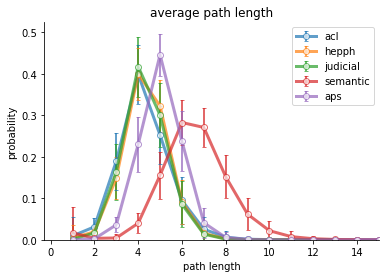

In [82]:
# DATASETS
ax = plt.subplot()

for file_ in files:
    fpath = os.path.join(fld_path, '{}.txt'.format(file_)) 
    xk, pk, pk_std = map(np.array, pl_data[file_])
    ax.errorbar(xk, pk, yerr=.5*pk_std, elinewidth=2, capsize=2, label=file_, marker='o', lw=3, mfc='w', alpha=0.7)
    
ax.set_xlim(right=15)
ax.set_ylim(bottom=0)
utils.update_ax(ax, 'average path length', 'path length', 'probability')